## Ising Model Inference

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from tqdm import tqdm
import pandas as pd

In [2]:
def get_nearest_neighbours(i, j, N):
    # only right and below neighbours to avoid double counting
    neighbors = []
    if i > 0:
        neighbors.append((i-1, j))
    if i < N-1:
        neighbors.append((i+1, j))
    if j > 0:
        neighbors.append((i, j-1))
    if j < N-1:
        neighbors.append((i, j+1))
        
    return neighbors

In [3]:
def initial_state(N):
    return np.random.choice([-1, 1], size=(N, N))

In [4]:
betas = [4, 1, 0.01]

In [5]:
def boltzmann(beta):
    return {'11': np.exp(beta),
           '1-1': np.exp(0),
           '-11': np.exp(0),
           '-1-1': np.exp(beta)}

## Mean Field Approximation

In [6]:
def proposal_distribution(alpha):
    q = np.exp(alpha) / (np.exp(alpha) + np.exp(-alpha))
    return q

In [7]:
def mean_field_approx(max_iter=10, beta=1, N=10):
    
    # initialise the state
    state = initial_state(N)
    initial = state.copy()

    potentials = boltzmann(beta)
    samples = []
    # Initial alpha
    alpha = 100
    
    # Initial spin distribution of each individual spin being in +1 state
    qn = np.ones((N, N)) * (1 / (1 + np.exp(-2*alpha)))
    
    for _ in tqdm(range(max_iter)):

        for i in range(N):
            for j in range(N):
                
                qn[i,j] = 0                

                for n in get_nearest_neighbours(i, j, N):
                    
                    qn[i,j] += beta * np.tanh(qn[n[0],n[1]])
                    
                u = np.random.uniform()
                q = qn[i,j]
                if u < q:
                    state[i,j] = 1
                else:
                    state[i,j] = -1
                    
    return qn

In [8]:
marginalsMF = []

for beta in betas:

    qn = mean_field_approx(max_iter=100, beta=beta, N=10)
    qn = proposal_distribution(qn)
    marginalsMF.append(qn)

100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 665.77it/s]


In [ ]:
## Adaptation for running Isaac's code
marginalsMF = []

for beta in betas:

    alpha, iter = coordinate_ascent(max_iter=10000, beta=0.01, N=10, tolerance=1e-10)
    alpha = proposal_distribution(qn)
    marginalsMF.append(qn)

In [9]:
p_tablesMF = []

for i in range(len(betas)):
    
    tab = np.zeros((2, 2))
    
    # Probability tables for (+1,+1), (+1,-1), (-1, +1) and (-1, -1)
    # for the top right and bottom right nodes
    
    tab[0,0] = marginalsMF[i][0, 9] * marginalsMF[i][9, 9]
    tab[0,1] = marginalsMF[i][0, 9] * (1 - marginalsMF[i][9, 9])
    tab[1,0] = (1-marginalsMF[i][0, 9]) * marginalsMF[i][9, 9]
    tab[1,1] = (1-marginalsMF[i][0, 9]) * (1-marginalsMF[i][9, 9])
    
    p_tablesMF.append(tab)
    
for i in range(len(betas)):
    print("Beta=" + str(betas[i]))
    print(p_tablesMF[i])
    print("\n")

Beta=4
[[9.99999775e-01 1.12535150e-07]
 [1.12535150e-07 1.26641628e-14]]


Beta=1
[[9.63596535e-01 1.80329956e-02]
 [1.80329956e-02 3.37474160e-04]]


Beta=0.01
[[0.25 0.25]
 [0.25 0.25]]




## Gibb's Sampling

In [10]:
def gibbs_sampling(max_iter=10000, burn_in=100, beta=1.0, N=10):

    # initialise the state
    state = initial_state(N)
    initial = state.copy()

    potentials = boltzmann(beta)
    samples = []
    
    print("Processing...")
    for _ in range(max_iter):
        
        # Draw a coordinate at random 
        i, j = np.random.randint(0, N, size=2)
        

        # Calculate the free energy for si+ and si-
        E_splus, E_sminus = 0, 0
        J = 1
        
        for n in get_nearest_neighbours(i, j, N):
            E_splus += -0.5 * 1 * state[n[0], n[1]]
            E_sminus += -0.5 * -1 * state[n[0], n[1]]
        
        # Calculate delta E
        dE = E_splus - E_sminus
        
        # Conditional P
        cond_p = 1 / (1 + np.exp(beta * dE))
        
        # Draw a value U from a uniform distribution
        U = np.random.uniform()
        
        if U <= cond_p:
            state[i, j] = 1
        else:
            state[i, j] = -1

        #store the state
        samples.append(state.copy())
       
    print("Finished \n")

    return samples, initial, state

In [11]:
samps = []
finals = []

for beta in betas:

    samples, initial, final = gibbs_sampling(max_iter=3000000, burn_in=100, beta=beta, N=10)
    samps.append([samples])
    finals.append(final)

Processing...
Finished 

Processing...
Finished 

Processing...
Finished 



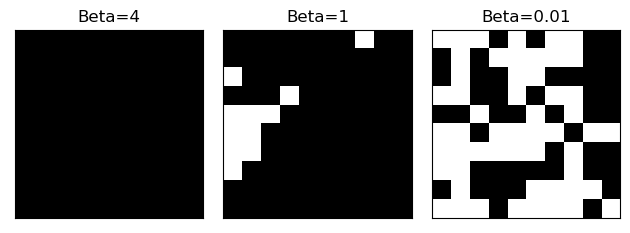

In [12]:
fig = plt.figure()
count = 0
rows, cols = 1, 3

for i in range(rows):
    for j in range(cols):
        plt.subplot(rows, cols, count + 1)
        plt.imshow(-1/finals[count], cmap="Greys_r")
        plt.title("Beta=" + str(betas[count]))# + ", Temp=" + str(1/betas[count]))
        
        ax = plt.gca()

        # Hide X and Y axes label marks
        ax.xaxis.set_tick_params(labelbottom=False)
        ax.yaxis.set_tick_params(labelleft=False)

        # Hide X and Y axes tick marks
        ax.set_xticks([])
        ax.set_yticks([])
        
        count += 1
        
plt.tight_layout()
plt.show()

In [13]:
def prob_distribution(samples, N=10):
    
    # compute the empirical distribution by counting the number of 
    # times each state is positive
    for i in range(len(samples)):
        samples[i] = (samples[i] == 1).astype(int)
    
    p = np.sum(samples, axis=0) / len(samples)

    return p

In [ ]:
marginals = []
joints = []

for i in range(3):
    print("Processing...")
    margs = prob_distribution(samps[i][0])
    joint = margs[0,9]*margs[9,9]
    
    marginals.append(margs)
    joints.append(joint)
    print("Completed")

Processing...
Completed
Processing...
Completed
Processing...


In [ ]:
p_tables = []

for i in range(len(betas)):
    
    tab = np.zeros((2, 2))
    
    # Probability tables for (+1,+1), (+1,-1), (-1, +1) and (-1, -1)
    # for the top right and bottom right nodes
    
    tab[0,0] = marginals[i][0, 9] * marginals[i][9, 9]
    tab[0,1] = marginals[i][0, 9] * (1 - marginals[i][9, 9])
    tab[1,0] = (1-marginals[i][0, 9]) * marginals[i][9, 9]
    tab[1,1] = (1-marginals[i][0, 9]) * (1-marginals[i][9, 9])
    
    p_tables.append(tab)
    
for i in range(len(betas)):
    print("Beta=" + str(betas[i]))
    print(p_tables[i])
    print("\n")